In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_fine']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_fine'])
df = df[df['y_fine'] >= 100000]
df = df[df['y_fine'] <= 15000000]

In [4]:
X = df.drop('y_fine', axis=1)
y = df['y_fine']/100000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

12947


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_3)

model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

In [12]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse', 'mae', 'mape'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     1657216     input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 662)]        0                                            
______________________________________________________________________________________________

In [13]:
history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=64, epochs=1000, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

Train on 909 samples, validate on 101 samples
Epoch 1/1000
909/909 [==============================] - 5s 6ms/sample - loss: 2138.9682 - mse: 2117.6531 - mae: 31.5027 - mape: 85.2042 - val_loss: 1841.5231 - val_mse: 1813.8119 - val_mae: 27.4639 - val_mape: 73.8908
Epoch 2/1000
909/909 [==============================] - 0s 308us/sample - loss: 1592.5413 - mse: 1558.1912 - mae: 25.7402 - mape: 119.7757 - val_loss: 1417.2183 - val_mse: 1373.7697 - val_mae: 23.9052 - val_mape: 109.7587
Epoch 3/1000
909/909 [==============================] - 0s 300us/sample - loss: 1279.0558 - mse: 1229.1982 - mae: 24.1734 - mape: 183.4175 - val_loss: 1266.8372 - val_mse: 1210.1733 - val_mae: 24.7987 - val_mape: 156.2204
Epoch 4/1000
909/909 [==============================] - 0s 306us/sample - loss: 1207.8531 - mse: 1148.6282 - mae: 25.1597 - mape: 232.1965 - val_loss: 1233.8138 - val_mse: 1173.4840 - val_mae: 25.3105 - val_mape: 169.0229
Epoch 5/1000
909/909 [==============================] - 0s 302us/sampl

Epoch 38/1000
909/909 [==============================] - 0s 308us/sample - loss: 775.6235 - mse: 688.2736 - mae: 19.4375 - mape: 164.6543 - val_loss: 1191.8850 - val_mse: 1103.9025 - val_mae: 23.8396 - val_mape: 132.8243
Epoch 39/1000
909/909 [==============================] - 0s 299us/sample - loss: 782.1062 - mse: 693.3408 - mae: 19.4320 - mape: 159.0231 - val_loss: 1190.3236 - val_mse: 1100.5804 - val_mae: 24.1500 - val_mape: 138.1104
Epoch 40/1000
909/909 [==============================] - 0s 308us/sample - loss: 778.0658 - mse: 688.0482 - mae: 19.4420 - mape: 163.0819 - val_loss: 1193.8113 - val_mse: 1103.2307 - val_mae: 23.9097 - val_mape: 133.8079
Epoch 41/1000
909/909 [==============================] - 0s 298us/sample - loss: 762.9317 - mse: 671.9779 - mae: 19.1500 - mape: 157.7053 - val_loss: 1196.0076 - val_mse: 1104.2711 - val_mae: 23.9234 - val_mape: 134.1120
Epoch 42/1000
909/909 [==============================] - 0s 299us/sample - loss: 747.1840 - mse: 654.5817 - mae: 18.

Epoch 75/1000
909/909 [==============================] - 0s 305us/sample - loss: 421.5470 - mse: 299.1782 - mae: 12.8407 - mape: 98.9035 - val_loss: 1186.7175 - val_mse: 1064.3826 - val_mae: 23.1385 - val_mape: 121.9067
Epoch 76/1000
909/909 [==============================] - 0s 304us/sample - loss: 421.6247 - mse: 299.2762 - mae: 12.5994 - mape: 84.4464 - val_loss: 1187.8010 - val_mse: 1065.3549 - val_mae: 23.0387 - val_mape: 120.5033
Epoch 77/1000
909/909 [==============================] - 0s 313us/sample - loss: 400.7825 - mse: 278.1053 - mae: 12.4585 - mape: 97.8677 - val_loss: 1180.7958 - val_mse: 1057.9534 - val_mae: 22.9928 - val_mape: 121.1502
Epoch 78/1000
909/909 [==============================] - 0s 303us/sample - loss: 397.2606 - mse: 274.2300 - mae: 12.2811 - mape: 93.9103 - val_loss: 1191.5919 - val_mse: 1068.4877 - val_mae: 22.7962 - val_mape: 115.2392
Epoch 79/1000
909/909 [==============================] - 0s 304us/sample - loss: 366.5451 - mse: 243.3864 - mae: 11.5230

909/909 [==============================] - 0s 313us/sample - loss: 264.9851 - mse: 150.4808 - mae: 9.0544 - mape: 61.5546 - val_loss: 1167.1006 - val_mse: 1052.7545 - val_mae: 22.9289 - val_mape: 123.6196
Epoch 111/1000
909/909 [==============================] - 0s 306us/sample - loss: 245.1035 - mse: 131.1024 - mae: 8.6350 - mape: 69.3930 - val_loss: 1167.0233 - val_mse: 1053.4169 - val_mae: 22.7852 - val_mape: 120.3751
Epoch 112/1000
909/909 [==============================] - 0s 307us/sample - loss: 253.2527 - mse: 139.8277 - mae: 8.8396 - mape: 56.2824 - val_loss: 1170.9779 - val_mse: 1057.7207 - val_mae: 22.8313 - val_mape: 119.7219
Epoch 113/1000
909/909 [==============================] - 0s 304us/sample - loss: 253.9838 - mse: 140.8497 - mae: 9.0084 - mape: 59.5352 - val_loss: 1174.3193 - val_mse: 1061.5249 - val_mae: 22.9761 - val_mape: 121.5165
Epoch 114/1000
909/909 [==============================] - 0s 306us/sample - loss: 253.8366 - mse: 141.0658 - mae: 8.9528 - mape: 63.690

909/909 [==============================] - 0s 318us/sample - loss: 187.3399 - mse: 96.0555 - mae: 7.4784 - mape: 51.8030 - val_loss: 1147.7616 - val_mse: 1056.8094 - val_mae: 23.2222 - val_mape: 126.9584
Epoch 147/1000
909/909 [==============================] - ETA: 0s - loss: 180.2037 - mse: 89.6564 - mae: 7.4223 - mape: 47.46 - 0s 309us/sample - loss: 182.0211 - mse: 91.5104 - mae: 7.4779 - mape: 49.4336 - val_loss: 1150.3786 - val_mse: 1060.2896 - val_mae: 23.1894 - val_mape: 124.3304
Epoch 148/1000
909/909 [==============================] - 0s 302us/sample - loss: 184.6303 - mse: 94.8368 - mae: 7.5308 - mape: 53.1964 - val_loss: 1159.7344 - val_mse: 1070.5002 - val_mae: 22.9482 - val_mape: 118.4360
Epoch 149/1000
909/909 [==============================] - 0s 318us/sample - loss: 178.7535 - mse: 89.7264 - mae: 7.2423 - mape: 47.2726 - val_loss: 1144.3548 - val_mse: 1055.5422 - val_mae: 23.6136 - val_mape: 132.3277
Epoch 150/1000
909/909 [==============================] - 0s 333us/sa

909/909 [==============================] - 0s 302us/sample - loss: 151.9282 - mse: 81.0543 - mae: 7.0457 - mape: 43.9389 - val_loss: 1136.7052 - val_mse: 1066.0315 - val_mae: 23.6758 - val_mape: 130.4282
Epoch 184/1000
909/909 [==============================] - ETA: 0s - loss: 142.2462 - mse: 71.8889 - mae: 6.5261 - mape: 42.04 - 0s 302us/sample - loss: 141.3694 - mse: 71.0228 - mae: 6.4650 - mape: 41.3321 - val_loss: 1142.6318 - val_mse: 1072.3882 - val_mae: 23.8193 - val_mape: 130.4965
Epoch 185/1000
909/909 [==============================] - 0s 311us/sample - loss: 145.8559 - mse: 75.7912 - mae: 6.6498 - mape: 41.4295 - val_loss: 1140.1470 - val_mse: 1070.3558 - val_mae: 23.3634 - val_mape: 123.2752
Epoch 186/1000
909/909 [==============================] - 0s 305us/sample - loss: 149.9262 - mse: 80.1931 - mae: 6.8882 - mape: 45.0065 - val_loss: 1137.7257 - val_mse: 1068.1218 - val_mae: 23.6194 - val_mape: 127.8743
Epoch 187/1000
909/909 [==============================] - 0s 303us/sa

Epoch 220/1000
909/909 [==============================] - 0s 303us/sample - loss: 121.1780 - mse: 62.2413 - mae: 6.1419 - mape: 42.2099 - val_loss: 1131.5218 - val_mse: 1072.6564 - val_mae: 24.0066 - val_mape: 133.2579
Epoch 221/1000
909/909 [==============================] - 0s 307us/sample - loss: 121.6744 - mse: 62.9551 - mae: 6.1888 - mape: 39.5602 - val_loss: 1116.9221 - val_mse: 1058.4722 - val_mae: 23.3551 - val_mape: 125.7364
Epoch 222/1000
909/909 [==============================] - 0s 300us/sample - loss: 121.5954 - mse: 63.3732 - mae: 6.1948 - mape: 40.5651 - val_loss: 1115.6046 - val_mse: 1057.6816 - val_mae: 23.4908 - val_mape: 126.8546
Epoch 223/1000
909/909 [==============================] - 0s 307us/sample - loss: 119.9220 - mse: 62.1270 - mae: 6.0747 - mape: 40.0163 - val_loss: 1125.2599 - val_mse: 1067.6110 - val_mae: 23.5334 - val_mape: 125.3602
Epoch 224/1000
909/909 [==============================] - 0s 309us/sample - loss: 117.2992 - mse: 59.6215 - mae: 5.9638 - ma

Epoch 256/1000
909/909 [==============================] - 0s 315us/sample - loss: 106.2382 - mse: 56.5864 - mae: 5.8268 - mape: 39.0791 - val_loss: 1126.7508 - val_mse: 1077.2024 - val_mae: 23.6481 - val_mape: 126.6086
Epoch 257/1000
909/909 [==============================] - 0s 307us/sample - loss: 108.8269 - mse: 59.2157 - mae: 5.8864 - mape: 36.0814 - val_loss: 1137.5268 - val_mse: 1088.0468 - val_mae: 23.9731 - val_mape: 128.8891
Epoch 258/1000
909/909 [==============================] - 0s 298us/sample - loss: 105.3694 - mse: 55.9070 - mae: 5.7985 - mape: 39.1049 - val_loss: 1144.0630 - val_mse: 1094.8243 - val_mae: 23.8680 - val_mape: 125.5236
Epoch 259/1000
909/909 [==============================] - 0s 302us/sample - loss: 106.3356 - mse: 57.1437 - mae: 5.8664 - mape: 37.6432 - val_loss: 1132.6226 - val_mse: 1083.4547 - val_mae: 24.0215 - val_mape: 131.0232
Epoch 260/1000
909/909 [==============================] - 0s 324us/sample - loss: 109.2307 - mse: 59.9830 - mae: 5.9754 - ma

909/909 [==============================] - 0s 300us/sample - loss: 93.5784 - mse: 49.8083 - mae: 5.4284 - mape: 35.9992 - val_loss: 1134.0030 - val_mse: 1090.4022 - val_mae: 23.6308 - val_mape: 124.0624
Epoch 294/1000
909/909 [==============================] - 0s 302us/sample - loss: 95.9595 - mse: 52.4434 - mae: 5.6274 - mape: 39.5857 - val_loss: 1137.2583 - val_mse: 1093.8818 - val_mae: 24.1690 - val_mape: 129.6563
Epoch 295/1000
909/909 [==============================] - 0s 301us/sample - loss: 90.9187 - mse: 47.5694 - mae: 5.3168 - mape: 34.2031 - val_loss: 1145.0845 - val_mse: 1101.9146 - val_mae: 24.1944 - val_mape: 128.4671
Epoch 296/1000
909/909 [==============================] - 0s 304us/sample - loss: 88.0045 - mse: 44.9533 - mae: 5.2855 - mape: 35.0529 - val_loss: 1122.3856 - val_mse: 1079.5272 - val_mae: 24.0692 - val_mape: 129.7799
Epoch 297/1000
909/909 [==============================] - 0s 301us/sample - loss: 95.6276 - mse: 52.7638 - mae: 5.5846 - mape: 35.0621 - val_lo

909/909 [==============================] - 0s 300us/sample - loss: 83.1997 - mse: 44.6758 - mae: 5.2521 - mape: 33.6484 - val_loss: 1127.6556 - val_mse: 1089.0740 - val_mae: 24.7049 - val_mape: 138.2159
Epoch 331/1000
909/909 [==============================] - 0s 313us/sample - loss: 90.0971 - mse: 51.5921 - mae: 5.5671 - mape: 34.9478 - val_loss: 1133.8436 - val_mse: 1095.3855 - val_mae: 24.3734 - val_mape: 133.9244
Epoch 332/1000
909/909 [==============================] - 0s 315us/sample - loss: 82.4839 - mse: 44.0492 - mae: 5.0748 - mape: 32.7293 - val_loss: 1145.6117 - val_mse: 1107.2059 - val_mae: 24.4616 - val_mape: 130.8693
Epoch 333/1000
909/909 [==============================] - 0s 305us/sample - loss: 91.0989 - mse: 52.7100 - mae: 5.5124 - mape: 34.8780 - val_loss: 1132.6464 - val_mse: 1094.2853 - val_mae: 24.3756 - val_mape: 131.0706
Epoch 334/1000
909/909 [==============================] - 0s 306us/sample - loss: 88.7589 - mse: 50.4261 - mae: 5.6248 - mape: 36.6343 - val_lo

909/909 [==============================] - 0s 310us/sample - loss: 75.1568 - mse: 39.9551 - mae: 4.9595 - mape: 32.5235 - val_loss: 1142.2311 - val_mse: 1107.1418 - val_mae: 24.0855 - val_mape: 126.0025
Epoch 368/1000
909/909 [==============================] - 0s 302us/sample - loss: 82.3654 - mse: 47.3054 - mae: 5.2999 - mape: 32.5979 - val_loss: 1148.8539 - val_mse: 1113.8795 - val_mae: 24.4346 - val_mape: 131.1333
Epoch 369/1000
909/909 [==============================] - 0s 321us/sample - loss: 81.0189 - mse: 46.0710 - mae: 5.2624 - mape: 33.9373 - val_loss: 1149.8763 - val_mse: 1114.9655 - val_mae: 24.4293 - val_mape: 130.8596
Epoch 370/1000
909/909 [==============================] - 0s 315us/sample - loss: 78.0817 - mse: 43.1081 - mae: 4.9625 - mape: 34.0838 - val_loss: 1146.3576 - val_mse: 1111.3175 - val_mae: 24.6034 - val_mape: 134.7211
Epoch 371/1000
909/909 [==============================] - 0s 339us/sample - loss: 79.5326 - mse: 44.5128 - mae: 5.1422 - mape: 32.4210 - val_lo

909/909 [==============================] - 0s 305us/sample - loss: 78.3806 - mse: 45.6668 - mae: 5.1728 - mape: 34.4931 - val_loss: 1120.4019 - val_mse: 1087.8141 - val_mae: 24.4669 - val_mape: 130.4269
Epoch 405/1000
909/909 [==============================] - 0s 309us/sample - loss: 74.9611 - mse: 42.3132 - mae: 4.9631 - mape: 30.7466 - val_loss: 1129.5275 - val_mse: 1096.7775 - val_mae: 24.4799 - val_mape: 131.2733
Epoch 406/1000
909/909 [==============================] - 0s 312us/sample - loss: 78.6416 - mse: 45.9010 - mae: 5.2491 - mape: 33.4579 - val_loss: 1132.7789 - val_mse: 1100.1335 - val_mae: 24.4440 - val_mape: 130.4281
Epoch 407/1000
909/909 [==============================] - ETA: 0s - loss: 72.5190 - mse: 39.9230 - mae: 4.8481 - mape: 32.833 - 0s 300us/sample - loss: 73.4803 - mse: 40.8860 - mae: 4.9027 - mape: 32.1877 - val_loss: 1137.6653 - val_mse: 1105.0547 - val_mae: 24.3838 - val_mape: 130.0457
Epoch 408/1000
909/909 [==============================] - ETA: 0s - loss:

909/909 [==============================] - 0s 305us/sample - loss: 70.5022 - mse: 39.7525 - mae: 4.8012 - mape: 30.4268 - val_loss: 1124.9510 - val_mse: 1094.2987 - val_mae: 24.5009 - val_mape: 132.8711
Epoch 441/1000
909/909 [==============================] - 0s 310us/sample - loss: 77.1238 - mse: 46.5335 - mae: 5.0858 - mape: 31.2538 - val_loss: 1128.9372 - val_mse: 1098.3453 - val_mae: 24.3078 - val_mape: 128.9543
Epoch 442/1000
909/909 [==============================] - 0s 326us/sample - loss: 73.3309 - mse: 42.7727 - mae: 4.8640 - mape: 33.4954 - val_loss: 1095.7168 - val_mse: 1065.2070 - val_mae: 23.8797 - val_mape: 126.6155
Epoch 443/1000
909/909 [==============================] - 0s 302us/sample - loss: 75.7236 - mse: 45.2545 - mae: 5.0896 - mape: 32.5221 - val_loss: 1115.0818 - val_mse: 1084.6074 - val_mae: 23.8009 - val_mape: 123.7904
Epoch 444/1000
909/909 [==============================] - 0s 316us/sample - loss: 70.4017 - mse: 39.9129 - mae: 4.8165 - mape: 32.5514 - val_lo

Epoch 478/1000
909/909 [==============================] - 0s 304us/sample - loss: 69.3943 - mse: 40.4419 - mae: 4.8921 - mape: 31.3675 - val_loss: 1115.0713 - val_mse: 1086.0366 - val_mae: 24.7033 - val_mape: 135.7741
Epoch 479/1000
909/909 [==============================] - 0s 330us/sample - loss: 67.6888 - mse: 38.6775 - mae: 4.7089 - mape: 31.4387 - val_loss: 1118.8423 - val_mse: 1089.8181 - val_mae: 24.5173 - val_mape: 133.4895
Epoch 480/1000
909/909 [==============================] - 0s 321us/sample - loss: 70.9391 - mse: 42.0279 - mae: 4.8363 - mape: 30.4737 - val_loss: 1118.1219 - val_mse: 1089.3143 - val_mae: 24.1810 - val_mape: 127.9286
Epoch 481/1000
909/909 [==============================] - 0s 325us/sample - loss: 66.6160 - mse: 37.8202 - mae: 4.6524 - mape: 31.1383 - val_loss: 1127.3255 - val_mse: 1098.5299 - val_mae: 23.8582 - val_mape: 122.7661
Epoch 482/1000
909/909 [==============================] - 0s 313us/sample - loss: 69.9195 - mse: 41.0875 - mae: 4.8761 - mape: 3

Epoch 516/1000
909/909 [==============================] - 0s 306us/sample - loss: 65.6437 - mse: 37.8893 - mae: 4.5781 - mape: 28.3974 - val_loss: 1118.9195 - val_mse: 1091.2610 - val_mae: 23.9585 - val_mape: 123.3099
Epoch 517/1000
909/909 [==============================] - 0s 304us/sample - loss: 68.4384 - mse: 40.7613 - mae: 4.8074 - mape: 29.4370 - val_loss: 1111.0289 - val_mse: 1083.3762 - val_mae: 24.1011 - val_mape: 125.4311
Epoch 518/1000
909/909 [==============================] - 0s 310us/sample - loss: 62.8311 - mse: 35.1880 - mae: 4.5063 - mape: 28.4811 - val_loss: 1119.2561 - val_mse: 1091.6116 - val_mae: 24.2055 - val_mape: 126.1741
Epoch 519/1000
909/909 [==============================] - 0s 304us/sample - loss: 68.6194 - mse: 40.9853 - mae: 4.7314 - mape: 30.2192 - val_loss: 1117.9441 - val_mse: 1090.2964 - val_mae: 24.4032 - val_mape: 129.2724
Epoch 520/1000
909/909 [==============================] - 0s 308us/sample - loss: 66.4485 - mse: 38.8097 - mae: 4.6551 - mape: 2

Epoch 553/1000
909/909 [==============================] - ETA: 0s - loss: 67.0358 - mse: 40.4358 - mae: 4.7182 - mape: 29.630 - 0s 307us/sample - loss: 67.0671 - mse: 40.4647 - mae: 4.7319 - mape: 29.6005 - val_loss: 1114.2293 - val_mse: 1087.5918 - val_mae: 24.3009 - val_mape: 128.7247
Epoch 554/1000
909/909 [==============================] - 0s 316us/sample - loss: 62.6064 - mse: 36.0029 - mae: 4.6064 - mape: 28.0236 - val_loss: 1113.4324 - val_mse: 1086.9351 - val_mae: 24.1010 - val_mape: 127.2241
Epoch 555/1000
909/909 [==============================] - 0s 311us/sample - loss: 62.4976 - mse: 36.0538 - mae: 4.5313 - mape: 30.2637 - val_loss: 1111.9458 - val_mse: 1085.5238 - val_mae: 23.9930 - val_mape: 126.5845
Epoch 556/1000
909/909 [==============================] - 0s 308us/sample - loss: 64.0410 - mse: 37.6105 - mae: 4.5809 - mape: 29.1756 - val_loss: 1114.6199 - val_mse: 1088.2489 - val_mae: 23.7727 - val_mape: 123.5252
Epoch 557/1000
909/909 [==============================] - 

909/909 [==============================] - 0s 304us/sample - loss: 61.2413 - mse: 35.5386 - mae: 4.3998 - mape: 27.3194 - val_loss: 1112.8971 - val_mse: 1087.2175 - val_mae: 24.1515 - val_mape: 124.5584
Epoch 591/1000
909/909 [==============================] - 0s 307us/sample - loss: 60.4159 - mse: 34.7959 - mae: 4.4380 - mape: 28.9640 - val_loss: 1110.0450 - val_mse: 1084.5090 - val_mae: 24.0181 - val_mape: 123.5632
Epoch 592/1000
909/909 [==============================] - 0s 302us/sample - loss: 60.0068 - mse: 34.4765 - mae: 4.3946 - mape: 28.1528 - val_loss: 1114.4434 - val_mse: 1088.9672 - val_mae: 23.9788 - val_mape: 122.5009
Epoch 593/1000
909/909 [==============================] - 0s 307us/sample - loss: 61.3332 - mse: 35.8921 - mae: 4.5366 - mape: 27.8648 - val_loss: 1099.4540 - val_mse: 1074.0552 - val_mae: 24.0529 - val_mape: 125.4093
Epoch 594/1000
909/909 [==============================] - 0s 321us/sample - loss: 56.8828 - mse: 31.4921 - mae: 4.2327 - mape: 27.6527 - val_lo

Epoch 628/1000
909/909 [==============================] - 0s 313us/sample - loss: 63.2599 - mse: 38.8666 - mae: 4.6069 - mape: 29.4331 - val_loss: 1088.0808 - val_mse: 1063.6021 - val_mae: 23.8719 - val_mape: 123.5442
Epoch 629/1000
909/909 [==============================] - ETA: 0s - loss: 57.4013 - mse: 32.8245 - mae: 4.3268 - mape: 28.5944- ETA: 0s - loss: 55.3040 - mse: 30.7337 - mae: 4.2881 - mape: 28.17 - 0s 314us/sample - loss: 57.2084 - mse: 32.6279 - mae: 4.3128 - mape: 28.1190 - val_loss: 1083.6962 - val_mse: 1059.0582 - val_mae: 23.8794 - val_mape: 123.9791
Epoch 630/1000
909/909 [==============================] - 0s 314us/sample - loss: 59.5565 - mse: 34.9760 - mae: 4.4367 - mape: 31.1238 - val_loss: 1075.8959 - val_mse: 1051.3293 - val_mae: 23.9535 - val_mape: 125.4725
Epoch 631/1000
909/909 [==============================] - 0s 309us/sample - loss: 58.9598 - mse: 34.4447 - mae: 4.4032 - mape: 27.7338 - val_loss: 1079.0337 - val_mse: 1054.5406 - val_mae: 23.8650 - val_mape

Epoch 665/1000
909/909 [==============================] - 0s 306us/sample - loss: 61.2487 - mse: 37.5631 - mae: 4.5684 - mape: 28.7142 - val_loss: 1083.7568 - val_mse: 1059.9857 - val_mae: 23.9607 - val_mape: 124.3772
Epoch 666/1000
909/909 [==============================] - 0s 304us/sample - loss: 58.6379 - mse: 34.8911 - mae: 4.5021 - mape: 27.4594 - val_loss: 1076.9253 - val_mse: 1053.2000 - val_mae: 24.0826 - val_mape: 126.5335
Epoch 667/1000
909/909 [==============================] - 0s 309us/sample - loss: 57.5619 - mse: 33.8352 - mae: 4.4224 - mape: 27.7909 - val_loss: 1065.5982 - val_mse: 1041.8092 - val_mae: 24.0286 - val_mape: 126.2357
Epoch 668/1000
909/909 [==============================] - 0s 304us/sample - loss: 58.5214 - mse: 34.7393 - mae: 4.4366 - mape: 30.2082 - val_loss: 1065.2646 - val_mse: 1041.5194 - val_mae: 23.7368 - val_mape: 122.6744
Epoch 669/1000
909/909 [==============================] - 0s 307us/sample - loss: 59.5822 - mse: 35.8577 - mae: 4.4597 - mape: 2

Epoch 702/1000
909/909 [==============================] - 0s 326us/sample - loss: 54.1902 - mse: 31.1855 - mae: 4.1836 - mape: 26.7511 - val_loss: 1090.8380 - val_mse: 1067.8544 - val_mae: 23.8700 - val_mape: 124.5759
Epoch 703/1000
909/909 [==============================] - 0s 311us/sample - loss: 54.1788 - mse: 31.2703 - mae: 4.2196 - mape: 27.5862 - val_loss: 1093.0902 - val_mse: 1070.2361 - val_mae: 23.8351 - val_mape: 123.0610
Epoch 704/1000
909/909 [==============================] - 0s 313us/sample - loss: 57.7980 - mse: 34.9419 - mae: 4.2596 - mape: 25.1378 - val_loss: 1115.8241 - val_mse: 1093.0233 - val_mae: 23.5310 - val_mape: 115.9332
Epoch 705/1000
909/909 [==============================] - 0s 314us/sample - loss: 54.7464 - mse: 31.9198 - mae: 4.2759 - mape: 28.2892 - val_loss: 1093.4682 - val_mse: 1070.6140 - val_mae: 23.7420 - val_mape: 120.4642
Epoch 706/1000
909/909 [==============================] - 0s 310us/sample - loss: 59.1730 - mse: 36.2449 - mae: 4.3853 - mape: 2

909/909 [==============================] - 0s 316us/sample - loss: 56.6609 - mse: 34.3206 - mae: 4.3944 - mape: 27.3839 - val_loss: 1095.8028 - val_mse: 1073.4167 - val_mae: 23.5374 - val_mape: 119.4406
Epoch 740/1000
909/909 [==============================] - 0s 329us/sample - loss: 54.5977 - mse: 32.1783 - mae: 4.1691 - mape: 26.0670 - val_loss: 1082.7623 - val_mse: 1060.3306 - val_mae: 23.8831 - val_mape: 123.6414
Epoch 741/1000
909/909 [==============================] - 0s 316us/sample - loss: 54.0428 - mse: 31.6543 - mae: 4.1938 - mape: 28.0312 - val_loss: 1082.3090 - val_mse: 1059.9208 - val_mae: 23.9815 - val_mape: 124.6331
Epoch 742/1000
909/909 [==============================] - 0s 320us/sample - loss: 54.3210 - mse: 31.9750 - mae: 4.3260 - mape: 26.9940 - val_loss: 1091.8655 - val_mse: 1069.5161 - val_mae: 23.8232 - val_mape: 122.27010098 - mse: 33.6663 - mae: 4.3932 - mape: 26.5
Epoch 743/1000
909/909 [==============================] - 0s 331us/sample - loss: 55.0621 - mse: 

909/909 [==============================] - 0s 311us/sample - loss: 56.6415 - mse: 34.4793 - mae: 4.3343 - mape: 27.3435 - val_loss: 1096.5477 - val_mse: 1074.3823 - val_mae: 23.5925 - val_mape: 118.5594
Epoch 777/1000
909/909 [==============================] - 0s 312us/sample - loss: 54.6180 - mse: 32.4367 - mae: 4.2227 - mape: 25.5354 - val_loss: 1087.9311 - val_mse: 1065.7924 - val_mae: 23.3431 - val_mape: 114.7671
Epoch 778/1000
909/909 [==============================] - 0s 314us/sample - loss: 53.6840 - mse: 31.5217 - mae: 4.3138 - mape: 27.4746 - val_loss: 1080.7841 - val_mse: 1058.6343 - val_mae: 23.3357 - val_mape: 115.8575
Epoch 779/1000
909/909 [==============================] - 0s 308us/sample - loss: 56.6133 - mse: 34.3789 - mae: 4.3687 - mape: 26.7504 - val_loss: 1078.1683 - val_mse: 1055.8113 - val_mae: 23.7496 - val_mape: 120.7065
Epoch 780/1000
909/909 [==============================] - 0s 309us/sample - loss: 56.3315 - mse: 33.9276 - mae: 4.3741 - mape: 28.1512 - val_lo

Epoch 814/1000
909/909 [==============================] - 0s 312us/sample - loss: 53.0285 - mse: 31.3400 - mae: 4.1152 - mape: 25.9570 - val_loss: 1091.1464 - val_mse: 1069.4873 - val_mae: 23.6204 - val_mape: 117.4436
Epoch 815/1000
909/909 [==============================] - 0s 311us/sample - loss: 53.6081 - mse: 31.9310 - mae: 4.1048 - mape: 25.9343 - val_loss: 1077.0981 - val_mse: 1055.5341 - val_mae: 23.1317 - val_mape: 112.3061
Epoch 816/1000
909/909 [==============================] - 0s 313us/sample - loss: 51.5540 - mse: 30.0197 - mae: 4.0127 - mape: 25.3165 - val_loss: 1086.4661 - val_mse: 1064.9761 - val_mae: 23.4307 - val_mape: 117.0489
Epoch 817/1000
909/909 [==============================] - 0s 317us/sample - loss: 53.5483 - mse: 31.9634 - mae: 4.1317 - mape: 24.1038 - val_loss: 1080.9694 - val_mse: 1059.3568 - val_mae: 23.5996 - val_mape: 119.9398
Epoch 818/1000
909/909 [==============================] - 0s 309us/sample - loss: 52.9306 - mse: 31.2824 - mae: 4.1722 - mape: 2

909/909 [==============================] - 0s 310us/sample - loss: 54.6368 - mse: 33.7144 - mae: 4.2834 - mape: 26.1259 - val_loss: 1089.4271 - val_mse: 1068.5138 - val_mae: 23.6639 - val_mape: 120.2531
Epoch 852/1000
909/909 [==============================] - 0s 304us/sample - loss: 54.7962 - mse: 33.9679 - mae: 4.1619 - mape: 24.5245 - val_loss: 1084.0194 - val_mse: 1063.1801 - val_mae: 23.7843 - val_mape: 121.2715
Epoch 853/1000
909/909 [==============================] - 0s 305us/sample - loss: 51.9514 - mse: 31.0967 - mae: 4.0850 - mape: 26.1989 - val_loss: 1075.2294 - val_mse: 1054.2965 - val_mae: 23.5114 - val_mape: 119.9049
Epoch 854/1000
909/909 [==============================] - 0s 324us/sample - loss: 52.6873 - mse: 31.7185 - mae: 4.1174 - mape: 25.7680 - val_loss: 1079.2425 - val_mse: 1058.2286 - val_mae: 23.4369 - val_mape: 118.9997
Epoch 855/1000
909/909 [==============================] - 0s 317us/sample - loss: 52.9072 - mse: 31.8898 - mae: 4.1307 - mape: 25.8408 - val_lo

909/909 [==============================] - 0s 308us/sample - loss: 52.5368 - mse: 32.1357 - mae: 4.1816 - mape: 26.5231 - val_loss: 1095.1889 - val_mse: 1074.7550 - val_mae: 23.7950 - val_mape: 121.4810
Epoch 889/1000
909/909 [==============================] - 0s 331us/sample - loss: 50.6287 - mse: 30.1596 - mae: 4.1121 - mape: 25.2536 - val_loss: 1082.6673 - val_mse: 1062.2051 - val_mae: 23.8820 - val_mape: 122.4761
Epoch 890/1000
909/909 [==============================] - 0s 346us/sample - loss: 49.5680 - mse: 29.1582 - mae: 4.0014 - mape: 25.3704 - val_loss: 1091.0323 - val_mse: 1070.6102 - val_mae: 23.8005 - val_mape: 121.4847
Epoch 891/1000
909/909 [==============================] - 0s 325us/sample - loss: 54.3266 - mse: 33.9141 - mae: 4.1874 - mape: 26.1304 - val_loss: 1091.8758 - val_mse: 1071.4747 - val_mae: 23.9126 - val_mape: 122.4580
Epoch 892/1000
909/909 [==============================] - 0s 343us/sample - loss: 51.9038 - mse: 31.5251 - mae: 4.1401 - mape: 27.1008 - val_lo

909/909 [==============================] - 0s 314us/sample - loss: 53.2200 - mse: 32.8604 - mae: 4.2596 - mape: 26.6163 - val_loss: 1086.9260 - val_mse: 1066.5864 - val_mae: 24.1949 - val_mape: 127.4707
Epoch 926/1000
909/909 [==============================] - 0s 316us/sample - loss: 59.0040 - mse: 38.7002 - mae: 4.3799 - mape: 25.2640 - val_loss: 1104.6779 - val_mse: 1084.2620 - val_mae: 23.9557 - val_mape: 121.6154
Epoch 927/1000
909/909 [==============================] - 0s 348us/sample - loss: 51.1810 - mse: 30.7385 - mae: 4.0047 - mape: 24.5419 - val_loss: 1088.2411 - val_mse: 1067.7428 - val_mae: 23.8323 - val_mape: 123.3864
Epoch 928/1000
909/909 [==============================] - 0s 327us/sample - loss: 56.0843 - mse: 35.5839 - mae: 4.2715 - mape: 25.5348 - val_loss: 1089.0147 - val_mse: 1068.5447 - val_mae: 23.8415 - val_mape: 124.1252
Epoch 929/1000
909/909 [==============================] - 0s 338us/sample - loss: 55.6921 - mse: 35.2415 - mae: 4.4249 - mape: 26.5354 - val_lo

Epoch 963/1000
909/909 [==============================] - 0s 319us/sample - loss: 51.7079 - mse: 31.2229 - mae: 4.0305 - mape: 24.4114 - val_loss: 1073.3491 - val_mse: 1052.8396 - val_mae: 23.6496 - val_mape: 121.8709
Epoch 964/1000
909/909 [==============================] - 0s 305us/sample - loss: 51.7537 - mse: 31.3119 - mae: 4.1107 - mape: 25.4678 - val_loss: 1087.5536 - val_mse: 1067.1353 - val_mae: 23.8544 - val_mape: 123.7563
Epoch 965/1000
909/909 [==============================] - 0s 336us/sample - loss: 50.7057 - mse: 30.2988 - mae: 4.0980 - mape: 23.9140 - val_loss: 1093.9500 - val_mse: 1073.5082 - val_mae: 23.9756 - val_mape: 124.6015
Epoch 966/1000
909/909 [==============================] - 0s 325us/sample - loss: 53.5975 - mse: 33.2192 - mae: 4.2401 - mape: 26.3099 - val_loss: 1087.6329 - val_mse: 1067.2355 - val_mae: 24.1715 - val_mape: 126.7962
Epoch 967/1000
909/909 [==============================] - 0s 308us/sample - loss: 51.1894 - mse: 30.8409 - mae: 4.0876 - mape: 2

909/909 [==============================] - ETA: 0s - loss: 49.5850 - mse: 29.8704 - mae: 3.9158 - mape: 22.630 - 0s 312us/sample - loss: 49.5365 - mse: 29.8206 - mae: 3.9291 - mape: 23.3001 - val_loss: 1088.2477 - val_mse: 1068.5100 - val_mae: 24.1512 - val_mape: 125.7284


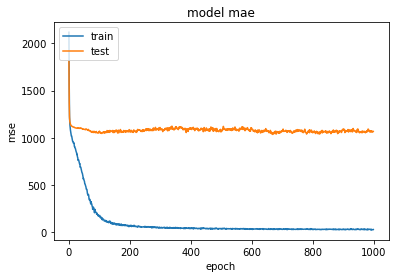

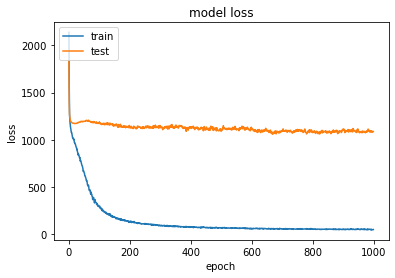

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [15]:
score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

113/113 [==============================] - 0s 2ms/sample - loss: 1351.0058 - mse: 1331.2681 - mae: 28.9514 - mape: 338.2877
[1351.0057913181001, 1331.2681, 28.951422, 338.2877]
Test Score: 1351.0057913181001
Test MSE: 1331.2681


In [16]:
# 300만원 이하 80만원